In [12]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import xrange

from astropy.io import ascii


In [49]:
1*10**(1.1)

12.589254117941675

In [410]:
################# Basic parameters (can be varied here) #################

n = 10          # Envelope density profile (6-12): steeper profile -> slower rise, broader LC
delta = 0      # Core density profile. Should be quite flat (delta<3). LC pretty insensitive

s = 0         # CSM density profile. s=0 means uniform shell, s=2 means steady wind.

kappa = 0.2     # Opacity
R0 = 1e15       # INNER CSM radius - little effect in most sensible cases!

Mej = 90    # ejecta mass in Msun
Mni = 0   # nickel mass
Mcsm = 7   # CSM mass
rho = 10**-11    # density of CSM shell (inner edge) 

E_51 = 2      # Kinetic energy of explosion in 10^51 erg

#R0 = (9.72e+17/rho)**(1./s)
shift = -5

t_end =  700 #2100    # last day of light curve
n_points = 1000 # number of time steps at which to compute integral

time = np.linspace(0.001,t_end,n_points)   # epochs for model LC output

1.1000946691454274
1.1004280024787607
35.245083932102915


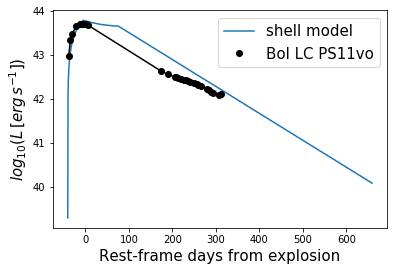

In [412]:

# constants ----------------------------------------------------------

c = 2.998e10    # speed of light in cm/s
Msun = 1.99e33  # solar mass
e_ni = 3.90e10  # energy release in 56Ni decay, erg/s/g
e_co = 6.78e9   # same for 56Co
tau_ni = 6.077*24*60*60/np.log(2)  # 56Ni decay time (half life/ln2)
tau_co = 77.27*24*60*60/np.log(2)  # 56Co decay time

# convert some quantities to physical units ---------------------------

Esn = E_51*1e51

#R0 = 1e13

# evaluate various coefficients and timescales required in later integrals -----------------------

g_n = 1/(4*np.pi*(n-delta))*(2*(5-delta)*(n-5)*Esn)**((n-3.)/2)/((3-delta)*(n-3)*Mej*Msun)**((n-5.)/2)  # g**n is scaling parameter for ejecta density profile

Vsn = np.sqrt(10*Esn/(3*Mej*Msun))    #ejecta velocity - NB this is not the same expression used in Chatzo paper (impossible to evaluate!), but LC is very insensitive to Vsn.

t_i = R0/Vsn    # time at which ejecta-CSM interaction begins

# B_f, B_r, A are constants that depend on ejecta and CSM density profiles; values taken from Table 1 of Chevalier 82
if s==0:
    if n==6:
        B_f = 1.256
        B_r = 0.906
        A = 2.4
    elif n==7:
        B_f = 1.181
        B_r = 0.935
        A = 1.2
    elif n==8:
        B_f = 1.154
        B_r = 0.950
        A = 0.71
    elif n==9:
        B_f = 1.140
        B_r = 0.960
        A = 0.47
    elif n==10:
        B_f = 1.131
        B_r = 0.966
        A = 0.33
    elif n==12:
        B_f = 1.121
        B_r = 0.974
        A = 0.19
    elif n==14:
        B_f = 1.116
        B_r = 0.979
        A = 0.12

if s==2:
    if n==6:
        B_f = 1.377
        B_r = 0.958
        A = 0.62
    elif n==7:
        B_f = 1.299
        B_r = 0.970
        A = 0.27
    elif n==8:
        B_f = 1.267
        B_r = 0.976
        A = 0.15
    elif n==9:
        B_f = 1.250
        B_r = 0.981
        A = 0.096
    elif n==10:
        B_f = 1.239
        B_r = 0.984
        A = 0.067
    elif n==12:
        B_f = 1.226
        B_r = 0.987
        A = 0.038
    elif n==14:
        B_f = 1.218
        B_r = 0.990
        A = 0.025

q = rho * R0**s    # scaling constant for CSM density profile; q = Rho_CSM for uniform shell (s=0).

R_csm = ((3.-s)/(4*np.pi*q)*Mcsm*Msun+R0**(3.-s))**(1/(3.-s))  # outer radius of CSM shell
import matplotlib.pyplot as plt
R_ph = abs((-2.*(1-s)/(3*kappa*q)+R_csm**(1.-s))**(1./(1-s))) # radius of photosphere (should be within CSM)

print (R_ph/1e15)

print (R_csm/1e15)

Mcsm_th = 4*np.pi*q/(3-s)*(R_ph**(3.-s)-R0**(3.-s))/Msun   # mass of the optically thick CSM (tau > 2/3)

t_FS = abs((3-s)*q**((3.-n)/(n-s))*(A*g_n)**((s-3.)/(n-s))/(4*np.pi*B_f**(3.-s)))**((n-s)/((n-3.)*(3-s)))*(Mcsm_th*Msun)**((n-s)/((n-3.)*(3-s)))    # time at which shock breaks out of optically thick CSM - forward shock power input then terminates

t_RS =  (Vsn/(B_r*(A*g_n/q)**(1./(n-s)))*(1-(3.-n)*Mej*Msun/(4*np.pi*Vsn**(3.-n)*g_n))**(1./(3-n)))**((n-s)/(s-3.))    # time at which reverse shock sweeps up all ejecta - reverse shock power input then terminates

t0 = (kappa*(Mej+Mcsm_th)*Msun)/(13.8*c*R_ph)  # diffusion timescale for radioactive energy input

t1 = (kappa*Mcsm*Msun)/(13.8*c*R_ph)   # diffusion timescale for shock energy in shell

Nintegrate = 1000   # Number of time steps to run integrals over

L = []

for i in xrange(n_points):    # Loop over time step i..for each time the solution is an integral over all previous time
    
    t = time[i]*24*3600   # Get time in seconds (t) from i
    
    z = np.linspace(0.000001,t,Nintegrate) # z is time in integral (i.e. t'); for each time t, we integrate function of z from 0 to t.
    
    # 56Ni part: -------------------------------
    
    integrand_ni = Mni*Msun/t0*np.exp(-t/t0)*(e_ni-e_co)*np.exp(z/t0-z/tau_ni)    # integrate this function to find luminosity due to nickel decay...
    
    L_ni = sum(integrand_ni*(t/Nintegrate))    # evaluate said integral from 0 to t numerically
    
    # 56Co part: --------------------------------
    
    integrand_co = Mni*Msun/t0*np.exp(-t/t0)*e_co*np.exp(z/t0-z/tau_co)
    
    L_co = sum(integrand_co*(t/Nintegrate))
    
    # Interaction part: -------------------------
     
    integrand_csm = (1/t1)*np.exp(-t/t1)*(np.exp(z/t1)*(2*np.pi/(n-s)**3.*g_n**((5.-s)/(n-s))*q**((n-5.)/(n-s))*(n-3)**2*(n-5)*B_f**(5.-s)*A**((5.-s)/(n-s))*(z+t_i)**((2.*n+6*s-n*s-15.)/(n-s))*((t_FS-z)>0) + 2*np.pi*(A*g_n/q)**((5.-n)/(n-s))*B_r**(5.-n)*g_n*((3.-s)/(n-s))**3*(z+t_i)**((2.*n+6*s-n*s-15.)/(n-s))*((t_RS-z)>0)))
    
    L_csm = sum(integrand_csm*(t/Nintegrate))
    
    # compute LC and chi2 -----------------------
    
    L_model_i = L_csm + L_ni + L_co    # Calculate luminosity
    
    L.append(L_model_i)

#########################################################################################################

L_plot = np.log10(L)

t_peak = time[np.argmax(L_plot)]

if s==0:
    label='Mej = %.2f Msun\nMcsm = %.2f Msun\nMni = %.2f Msun\nKinetic energy = %.2fe+51 erg\nPhotospheric radius = %.2e cm\nInner CSM density = %.2e g/cm3\nCSM profile: Shell' %(Mej,Mcsm,Mni,E_51,R_ph,rho)
if s==2:
    label='Mej = %.2f Msun\nMcsm = %.2f Msun\nMni = %.2f Msun\nKinetic energy = %.2fe+51 erg\nPhotospheric radius = %.2e cm\nInner CSM density = %.2e g/cm3\nCSM profile: Wind' %(Mej,Mcsm,Mni,E_51,R_ph,rho)

plt.plot(time-t_peak+shift,L_plot,label = 'shell model')
file1='bol2.csv'
data1 = ascii.read(file1,format='csv')
t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS11vo')
plt.errorbar(t,np.log10(lum),fmt = 'k')

#plt.legend()
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
ymin = 41.5
ymax = 44.2
#plt.ylim(ymin,ymax)6

try:
    xmax = time[len(L_plot[L_plot>ymin])]
except:
    xmax = time[-1]
#plt.ylim(40,44)
#plt.xlim(-5-t_peak,xmax)
#plt.show()
#plt.plot([-120,300],[np.max(L_plot)-np.log10(np.exp(1)),np.max(L_plot)-np.log10(np.exp(1))],linestyle='--',color='dimgrey')

T_phot = (np.array(L)/(4*np.pi*R_ph**2*5.67e-5))**0.25

out = zip(time-t_peak+shift,L_plot,T_phot)
print (t_FS/24/3600)

plt.savefig('ps11vo_wn2.pdf')

In [413]:
z = (time-t_peak+shift, L_plot)

In [414]:
np.savetxt('ps11vo_s.csv',np.transpose(z), delimiter = ',')

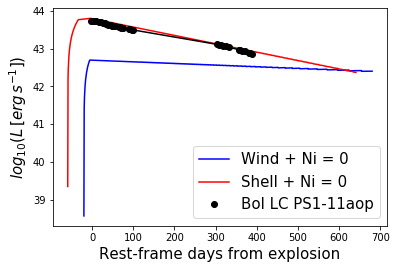

In [428]:
file1='nscorner3c.csv'
data1 = ascii.read(file1,format='csv')
file2='nwcorner3c.csv'
data2 = ascii.read(file2,format='csv')
file3='bol1.csv'
data3 = ascii.read(file3,format='csv')
t = data3['t']
lum = data3['lum']
lumerror =  data3['lum-error']
yerr =  lumerror
t2 = data2['t_nw']
logl2 = data2['l_nw']
t3 = data1['t_ns']
logl3 = data1['l_ns']

plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS1-11aop')
plt.errorbar(t,np.log10(lum),fmt = 'k')
plt.plot(t2,logl2,'b',label = 'Wind + Ni = 0')
plt.plot(t3,logl3,'r',label = 'Shell + Ni = 0')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
plt.savefig('nsnw.pdf')

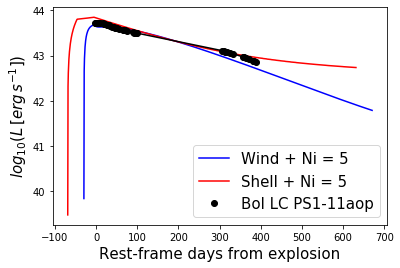

In [427]:
file1='sn1corner3c.csv'
data1 = ascii.read(file1,format='csv')
file2='wn1corner3c.csv'
data2 = ascii.read(file2,format='csv')
file3='bol1.csv'
data3 = ascii.read(file3,format='csv')
t = data3['t']
lum = data3['lum']
lumerror =  data3['lum-error']
yerr =  lumerror
t2 = data2['t_nw']
logl2 = data2['l_nw']
t3 = data1['t_ns']
logl3 = data1['l_ns']

plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS1-11aop')
plt.errorbar(t,np.log10(lum),fmt = 'k')
plt.plot(t2,logl2,'b',label = 'Wind + Ni = 5')
plt.plot(t3,logl3,'r',label = 'Shell + Ni = 5')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
#plt.savefig('n1sn1w.pdf')

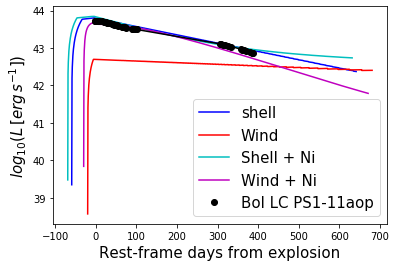

In [431]:
file1='nscorner3c.csv'
data1 = ascii.read(file1,format='csv')
file2='nwcorner3c.csv'
data2 = ascii.read(file2,format='csv')
file4='sn1corner3c.csv'
data4 = ascii.read(file4,format='csv')
file5='wn1corner3c.csv'
data5 = ascii.read(file5,format='csv')
file3='bol1.csv'
data3 = ascii.read(file3,format='csv')
t = data3['t']
lum = data3['lum']
lumerror =  data3['lum-error']
yerr =  lumerror
t1 = data1['t_ns']
logl1 = data1['l_ns']
t2 = data2['t_nw']
logl2 = data2['l_nw']

t4 = data4['t_ns']
logl4 = data4['l_ns']
t5 = data5['t_nw']
logl5 = data5['l_nw']

plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS1-11aop')
plt.errorbar(t,np.log10(lum),fmt = 'k')
plt.plot(t1,logl1,'b',label = 'shell')
plt.plot(t2,logl2,'r',label = 'Wind')
plt.plot(t4,logl4,'c',label = 'Shell + Ni')
plt.plot(t5,logl5,'m',label = 'Wind + Ni')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)
plt.legend(fontsize =15)
plt.savefig('ps11aopsw.pdf')

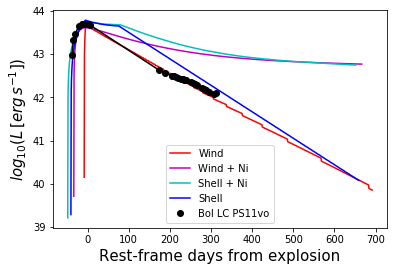

In [436]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol2.csv'
data1 = ascii.read(file1,format='csv')
file2='ps11vo_w.csv'
data2 = ascii.read(file2,format='csv')
file3='ps11vo_wn2.csv'
data3 = ascii.read(file3,format='csv')
file4='ps11vo_cn5.csv'
data4 = ascii.read(file4,format='csv')
file5='ps11vo_s.csv'
data5 = ascii.read(file5,format='csv')


logl1 = data2['l_w']
t1 = data2['t_w']
logl2 = data3['l_nw']
t2 = data3['t_nw']
logl3 = data4['l_ns']
t3 = data4['t_ns']
logl4 = data5['l_s']
t4 = data5['t_s']
t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'ko',label = 'Bol LC PS11vo')
plt.errorbar(t,np.log10(lum),fmt = 'k')
plt.plot(t1,logl1,'r',label = 'Wind')
plt.plot(t2,logl2,'m',label = 'Wind + Ni')
plt.plot(t3,logl3,'c',label = 'Shell + Ni')
plt.plot(t4,logl4,'b',label = 'Shell')
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('Rest-frame days from explosion',fontsize =15)
plt.ylabel(r'$log_{10}(\mathit{L}\,[erg\,s^{-1}])$', fontsize =15)


plt.legend(fontsize =10)
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()
plt.savefig('ps11vows.pdf')

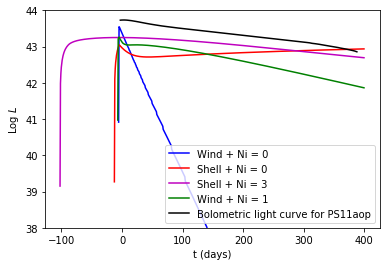

In [437]:
#testing for peak luminosity that matches the bolometric peak
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
file2='mod1.csv'
data2 = ascii.read(file2,format='csv')


logl1 = data2['l_now']
t1 = data2['t_now']
logl2 = data2['l_nos']
t2 = data2['t_nos']
logl3 = data2['l_ns']
t3 = data2['t_ns']
logl4 = data2['l_nw']
t4 = data2['t_nw']
t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1[0:580],logl1[0:580],'b',label = 'Wind + Ni = 0')
plt.plot(t2[0:589],logl2[0:589],'r',label = 'Shell + Ni = 0')
plt.plot(t3[0:717],logl3[0:717],'m',label = 'Shell + Ni = 3')
plt.plot(t4[0:581],logl4[0:581],'g',label = 'Wind + Ni = 1')
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
#plt.xlim(0.2,0.4)
plt.ylim(38,44)
plt.show()
#plt.savefig('mod1zoom.pdf')

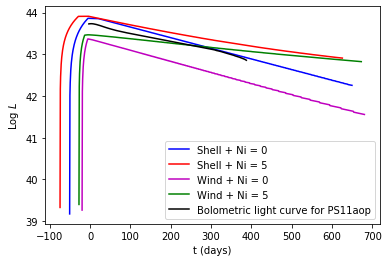

In [438]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
file3='cman.csv'
data3 = ascii.read(file3,format='csv')


logl1 = data3['logl_nos1']
t1 = data3['t_nos1']
logl2 = data3['logl_ns1']
t2 = data3['t_ns1']
logl3 = data3['logl_now1']
t3 = data3['t_now1']
logl4 = data3['logl_nw1']
t4 = data3['t_nw1']
t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Ni = 0')
plt.plot(t2,logl2,'r',label = 'Shell + Ni = 5')
plt.plot(t3,logl3,'m',label = 'Wind + Ni = 0')
plt.plot(t4,logl4,'g',label = 'Wind + Ni = 5')
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
plt.show()
#plt.savefig('cman1.pdf')

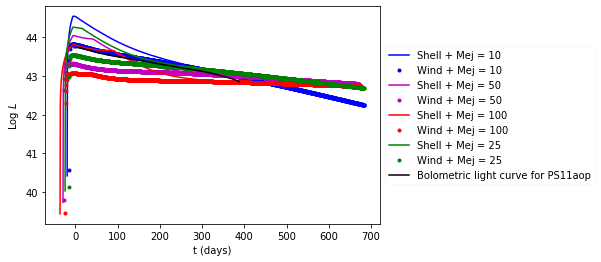

In [439]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
file4='cme.csv'
data4 = ascii.read(file4,format='csv')


logl1 = data4['l_ns1a']
t1 = data4['t_ns1a']
logl2 = data4['l_nw1a']
t2 = data4['t_nw1a']
logl3 = data4['l_ns1b']
t3 = data4['t_ns1b']
logl4 = data4['l_nw1b']
t4 = data4['t_nw1b']

logl5 = data4['l_ns1c']
t5 = data4['t_ns1c']
logl6 = data4['l_nw1c']
t6 = data4['t_nw1c']
logl7 = data4['l_ns1d']
t7 = data4['t_ns1d']
logl8 = data4['l_nw1d']
t8 = data4['t_nw1d']


t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Mej = 10')
plt.plot(t2,logl2,'b.',label = 'Wind + Mej = 10')
plt.plot(t3,logl3,'m',label = 'Shell + Mej = 50')
plt.plot(t4,logl4,'m.',label = 'Wind + Mej = 50')
plt.plot(t5,logl5,'r',label = 'Shell + Mej = 100')
plt.plot(t6,logl6,'r.',label = 'Wind + Mej = 100')
plt.plot(t7,logl7,'g',label = 'Shell + Mej = 25')
plt.plot(t8,logl8,'g.',label = 'Wind + Mej = 25')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
plt.show()
#plt.savefig('cme1.pdf')

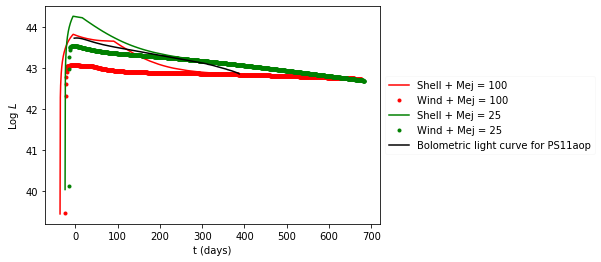

In [440]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t5,logl5,'r',label = 'Shell + Mej = 100')

plt.plot(t6,logl6,'r.',label = 'Wind + Mej = 100')
plt.plot(t7,logl7,'g',label = 'Shell + Mej = 25')
plt.plot(t8,logl8,'g.',label = 'Wind + Mej = 25')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

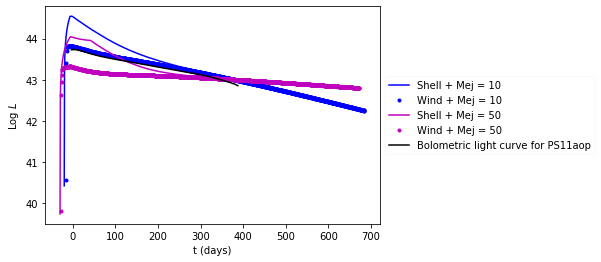

In [441]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Mej = 10')
plt.plot(t2,logl2,'b.',label = 'Wind + Mej = 10')
plt.plot(t3,logl3,'m',label = 'Shell + Mej = 50')
plt.plot(t4,logl4,'m.',label = 'Wind + Mej = 50')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

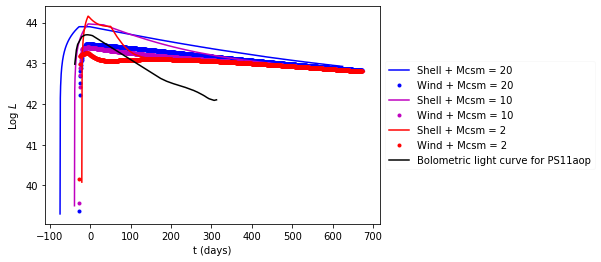

In [316]:
import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol2.csv'
data1 = ascii.read(file1,format='csv')
file5='cmcsm.csv'
data5 = ascii.read(file5,format='csv')


logl1 = data5['l_ns2a']
t1 = data5['t_ns2a']
logl2 = data5['l_nw2a']
t2 = data5['t_nw2a']
logl3 = data5['l_ns2b']
t3 = data5['t_ns2b']
logl4 = data5['l_nw2b']
t4 = data5['t_nw2b']

logl5 = data5['l_ns2c']
t5 = data5['t_ns2c']
logl6 = data5['l_nw2c']
t6 = data5['t_nw2c']
logl7 = data5['l_ns2c']

t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Mcsm = 20')
plt.plot(t2,logl2,'b.',label = 'Wind + Mcsm = 20')
plt.plot(t3,logl3,'m',label = 'Shell + Mcsm = 10')
plt.plot(t4,logl4,'m.',label = 'Wind + Mcsm = 10')
plt.plot(t5,logl5,'r',label = 'Shell + Mcsm = 2')
plt.plot(t6,logl6,'r.',label = 'Wind + Mcsm = 2')
#plt.plot(t7,logl7,'g',label = 'Shell + Mej = 25')
#plt.plot(t8,logl8,'g.',label = 'Wind + Mej = 25')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
plt.show()
#plt.savefig('cmcsm1.pdf')

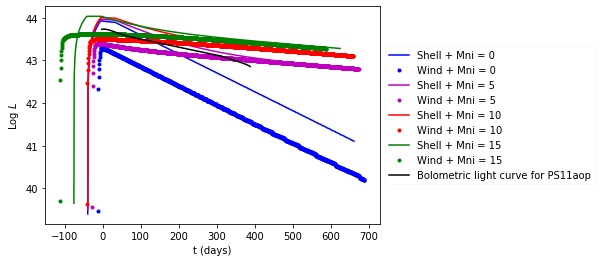

In [442]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
file6='cmni.csv'
data6 = ascii.read(file6,format='csv')


logl1 = data6['l_nos3a']
t1 = data6['t_nos3a']
logl2 = data6['l_now3a']
t2 = data6['t_now3a']
logl3 = data6['l_ns3b']
t3 = data6['t_ns3b']
logl4 = data6['l_nw3b']
t4 = data6['t_nw3b']

logl5 = data6['l_ns3c']
t5 = data6['t_ns3c']
logl6 = data6['l_nw3c']
t6 = data6['t_nw3c']
logl7 = data6['l_ns3d']
t7 = data6['t_ns3d']
logl8 = data6['l_nw3d']
t8 = data6['t_nw3d']


t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Mni = 0')
plt.plot(t2,logl2,'b.',label = 'Wind + Mni = 0')
plt.plot(t3,logl3,'m',label = 'Shell + Mni = 5')
plt.plot(t4,logl4,'m.',label = 'Wind + Mni = 5')
plt.plot(t5,logl5,'r',label = 'Shell + Mni = 10')
plt.plot(t6,logl6,'r.',label = 'Wind + Mni = 10')
plt.plot(t7,logl7,'g',label = 'Shell + Mni = 15')
plt.plot(t8,logl8,'g.',label = 'Wind + Mni = 15')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
plt.show()
#plt.savefig('cmni1.pdf')

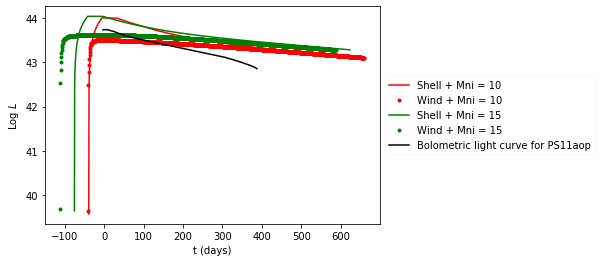

In [443]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t5,logl5,'r',label = 'Shell + Mni = 10')
plt.plot(t6,logl6,'r.',label = 'Wind + Mni = 10')
plt.plot(t7,logl7,'g',label = 'Shell + Mni = 15')
plt.plot(t8,logl8,'g.',label = 'Wind + Mni = 15')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

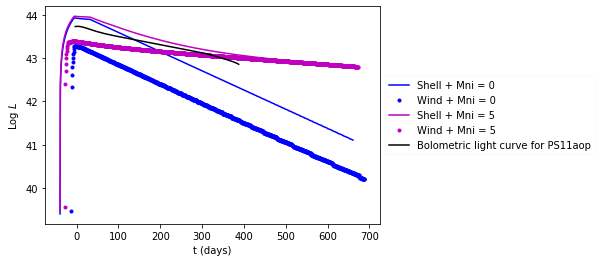

In [444]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + Mni = 0')
plt.plot(t2,logl2,'b.',label = 'Wind + Mni = 0')
plt.plot(t3,logl3,'m',label = 'Shell + Mni = 5')
plt.plot(t4,logl4,'m.',label = 'Wind + Mni = 5')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

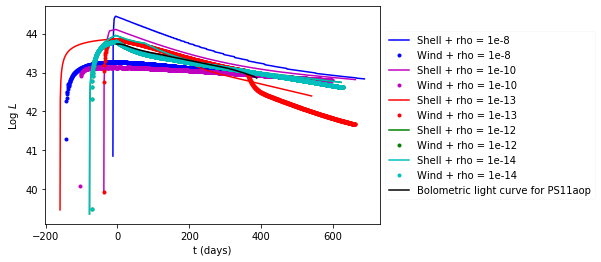

In [445]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

file1='bol1.csv'
data1 = ascii.read(file1,format='csv')
file7='crho.csv'
data7 = ascii.read(file7,format='csv')


logl1 = data7['l_ns4a']
t1 = data7['t_ns4a']
logl2 = data7['l_nw4a']
t2 = data7['t_nw4a']
logl3 = data7['l_ns4b']
t3 = data7['t_ns4b']
logl4 = data7['l_nw4b']
t4 = data7['t_nw4b']
logl5 = data7['l_ns4c']
t5 = data7['t_ns4c']

logl6 = data7['l_nw4c']
t6 = data7['t_nw4c']
logl7 = data7['l_ns4d']
t7 = data7['t_ns4d']
logl8 = data7['l_nw4d']
t8 = data7['t_nw4d']
logl9 = data7['l_ns4d']
t9 = data7['t_ns4d']
logl10 = data7['l_nw4d']
t10 = data7['t_nw4d']


t = data1['t']
lum = data1['lum']
lumerror =  data1['lum-error']
yerr =  lumerror
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + rho = 1e-8')
plt.plot(t2,logl2,'b.',label = 'Wind + rho = 1e-8')
plt.plot(t3,logl3,'m',label = 'Shell + rho = 1e-10')
plt.plot(t4,logl4,'m.',label = 'Wind + rho = 1e-10')
plt.plot(t5,logl5,'r',label = 'Shell + rho = 1e-13')
plt.plot(t6,logl6,'r.',label = 'Wind + rho = 1e-13')
plt.plot(t7,logl7,'g',label = 'Shell + rho = 1e-12')
plt.plot(t8,logl8,'g.',label = 'Wind + rho = 1e-12')
plt.plot(t9,logl9,'c',label = 'Shell + rho = 1e-14')
plt.plot(t10,logl10,'c.',label = 'Wind + rho = 1e-14')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
plt.show()
#plt.savefig('crho1.pdf')

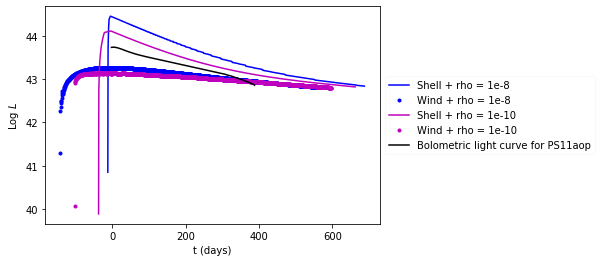

In [446]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')

plt.plot(t1,logl1,'b',label = 'Shell + rho = 1e-8')
plt.plot(t2,logl2,'b.',label = 'Wind + rho = 1e-8')
plt.plot(t3,logl3,'m',label = 'Shell + rho = 1e-10')
plt.plot(t4,logl4,'m.',label = 'Wind + rho = 1e-10')

plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

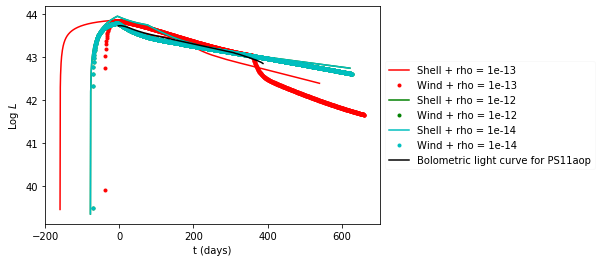

In [447]:
plt.errorbar(t,np.log10(lum),fmt = 'k',label = 'Bolometric light curve for PS11aop')
plt.plot(t5,logl5,'r',label = 'Shell + rho = 1e-13')
plt.plot(t6,logl6,'r.',label = 'Wind + rho = 1e-13')
plt.plot(t7,logl7,'g',label = 'Shell + rho = 1e-12')
plt.plot(t8,logl8,'g.',label = 'Wind + rho = 1e-12')
plt.plot(t9,logl9,'c',label = 'Shell + rho = 1e-14')
plt.plot(t10,logl10,'c.',label = 'Wind + rho = 1e-14')
#plt.scatter(logTeff,logL)
#plt.scatter(logTeff,logL)
#plt.yscale('log')
plt.xlabel('t (days)')

plt.ylabel(r'Log $L$')
#r'$\nu$ (GHz)', fontsize=20
plt.legend()
plt.legend(frameon=True, framealpha=0.1, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0.2,0.4)
#plt.ylim(38,44)
#plt.show()

In [ ]:
#for corner 3
